In [1]:
# This is my first Jupyter notebook, so it's quite amateur
# It runs in Google Colab
# Its input: Nicotine Web App output .csv files generated by http://inside-out.caltech.edu:9988
# The user places the files in the folder /content/drive/MyDrive/Colab_data/NWA_Data/NWA outputs/
# The input files have a variable time base, depedning on the integrator, the dose table, etc.
# and their length varies, from ~300 to ~ 10 MB.
# Most analysis programs don't treat this correctly.
# The user must make the folder, /content/drive/MyDrive/Colab_data/NWA_Data/Resampled_outputs/
# The routine then plae the resampled .txt files in the folder /content/drive/MyDrive/Colab_data/NWA_Data/Resampled_outputs/
# The resampled time base is 0.5 min.
# Some parts require upsampling; others, downsampling. Which is why I've not found a simple routine already written!
# the resampled file ~ 250 kB per day of simulation.
# I import these into Excel, for further analysis.
# Most time series analysis programs handle this correctly.
# For further comments, see Alexander Z, Wang, Janis Jeon, Fulden Buyukozturk, Ryan M. Drenan, and Henry A. Lester
# Mol Pharm 2024.
# Ignore the plotting error.
# Note that the routine wants your to press any key at times.
# The final cell usually has to be run twice (in order to flush a buffer?) before the output file appears.


import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.express as px
import csv
# no keyboard import necessary
from scipy.signal import find_peaks, peak_prominences
#HAL runs this on Google Colab:
from google.colab import drive
#This is required to find the data folder, HAL believes
drive.mount('/content/drive')
# !ls -l /content/drive/MyDrive

Mounted at /content/drive


# Normal

In [2]:
input_file_path= '/content/drive/MyDrive/Colab_data/NWA_Data/NWA outputs/'
input_core_name = 'Std habit 0.33 kel 0.5 smoking_datatable'
input_name = input_file_path + input_core_name
input_full_name = input_file_path + input_core_name + ".csv"
print("the input file will be:")
print (input_full_name)
input("Press the Enter key to continue: ")
#df_sh will be this routine's internal working name for any file we're resampling.
df_sh = pd.read_csv(input_full_name)


the input file will be:
/content/drive/MyDrive/Colab_data/NWA_Data/NWA outputs/Std habit 0.33 kel 0.5 smoking_datatable.csv
Press the Enter key to continue: 


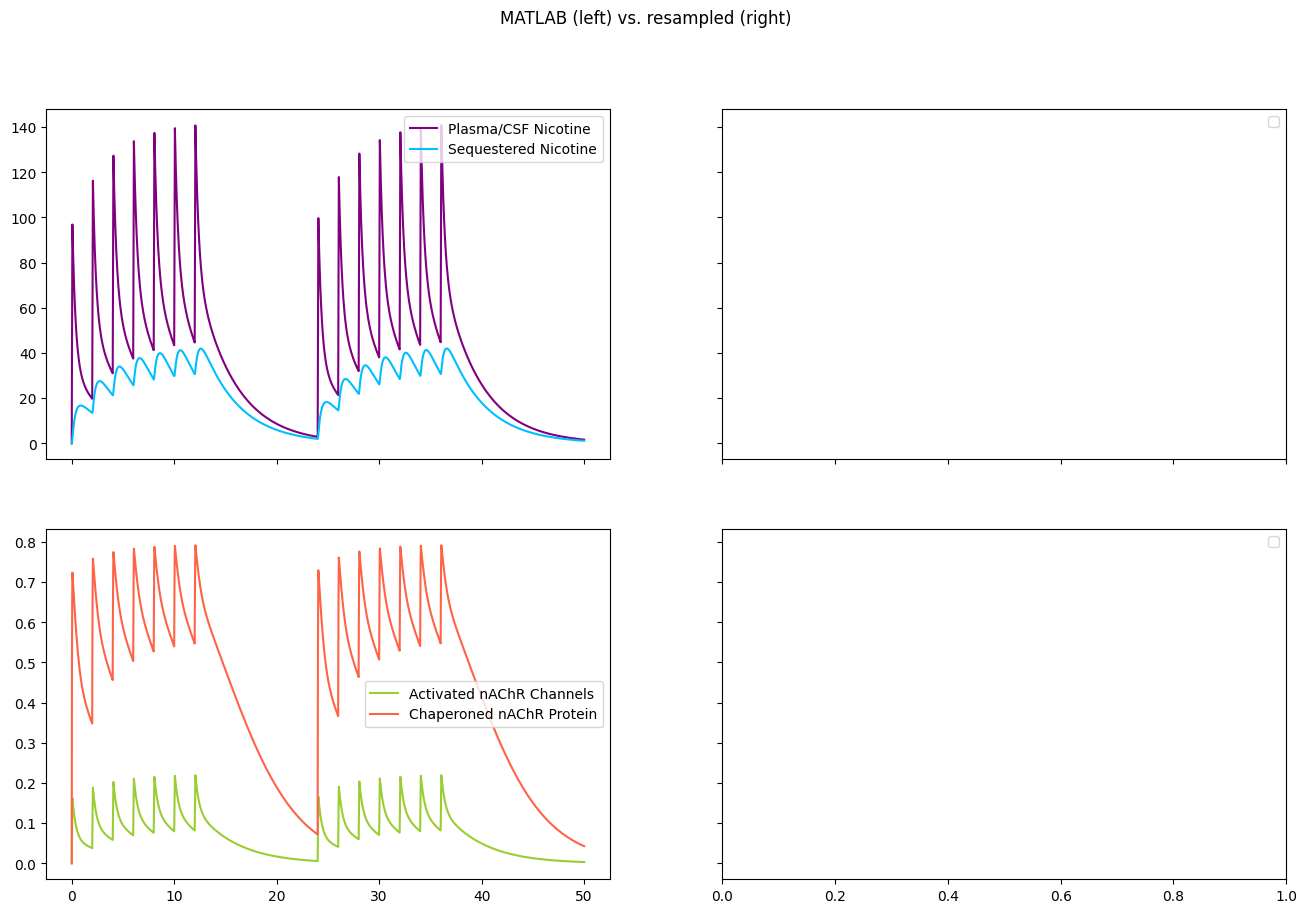

In [ ]:
fig, axs = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(16, 10))
axs[0,0].plot(df_sh['Time'], df_sh['Plasma/ CSF/ ER Nicotine'], label='Plasma/CSF Nicotine', color='purple')
axs[0,0].plot(df_sh['Time'], df_sh['Sequestered Nicotine'], label='Sequestered Nicotine', color='deepskyblue')



axs[1,0].plot(df_sh['Time'], df_sh['Fraction of Activated nAChR'], label='Activated nAChR Channels', color='yellowgreen')
axs[1,0].plot(df_sh['Time'], df_sh['Fraction of Chaperoned nAChR'], label='Chaperoned nAChR Protein', color='tomato')

#we'll have only set of plots.  On the left.
for i in range(2):
    for j in range(2):
        axs[i,j].legend()
plt.suptitle('MATLAB (left) vs. resampled (right)')
plt.show()

# HAL's conversion to 0.5 min time interval, 1 min = 1/60 h

In [3]:

from pandas.core.indexing import length_of_indexer
import time
#don't know whether that was nesssary
#simplify terminology
working_time_set = df_sh['Time']
wts = working_time_set
#print ("MATLAB simulated time set", wts)
working_dataset = df_sh['Plasma/ CSF/ ER Nicotine']
#the input file has four sets of simulated values. Internally, we name then wd, wd2, wd3, wd4.
wd = working_dataset
#print("MATLAB simulated nicotine concentrtations", wd)
working_dataset2 = df_sh['Sequestered Nicotine']
wd2 = working_dataset2
working_dataset3 = df_sh['Fraction of Activated nAChR']
wd3 = working_dataset3
working_dataset4 = df_sh['Fraction of Chaperoned nAChR']
wd4 = working_dataset4

#the inout dataset has the first time point at zero and the last at 50 h = 3000 min.
#more general,
max_mins = 3000
#therefore, we make the list floating-point half-minutes, 0 to max_mins
time_range = max_mins*2 + 1
half_minutes = [0.0]*time_range
for i in range(time_range):
#  half_minutes[i] = (float(i)+2.0)*0.5
  half_minutes[i] = (float(i))*0.5
  continue
#print(half_minutes)
#input("Press the Enter key to continue: ")
#firstly, we make the smoothing (when the integrator intervals are smaller than 0.5 minute)
#as part of this, we make the smoothed output array and fill it with "Nan" entries
#swd = smoothed working dataset
swd = [float("NaN")]*time_range
swd2 = [float("NaN")]*time_range
swd3 = [float("NaN")]*time_range
swd4 = [float("NaN")]*time_range
#print (swd, wd2, wd3, wd4)
#initializing parameters:
integration_start = 0
integration_finish = 0
average = 0
average_count = 0.0
sum = 0.0
sum2 = 0.0
sum3 = 0.0
sum4 = 0.0
#we'll need to save several loop indexes
eye = 0
jay = 0
em = 0
#and a constant, to speed things
sixty=60.0

#the outer i-loop runs by evenly spaced half-minutes:
for i in range(0,(time_range)):
  #initialize the floating-point count and running sum for this half-minute:
  average_count=0.0
  average = 0.0
  sum = sum2 = sum3 = sum4 = 0.0
  eye = i
  em = 0
  #the inner j- and m-loops keep time by MATLAB's hours (0 to 50):
  #we have to include both the beginning and the end points!
  #it's MATLAB's integrator, but we have stolen the word "integrate" for this routine
  for j in range(integration_finish,len(wd)-1):
    #the previous statement should save nearly ~50% of time
    jay = j
    #we look for MATLAB minutes that match the range between evenly-spaced haf-minutes:
    #have to end on the whole- or half-minute to avoid disorting "corners"
    #if sixty*((wts[j])) > (half_minutes[i] - 0.25):
    if sixty*((wts[j])) > (half_minutes[eye]):
        integration_start = j
        #we found the start of a possible integration region
        # we ask whether the next sample lies within the time window.
        #we initalize the count and the sums
        average_count = 0.0
        average = 0.0
        sum = sum2 = sum3 = sum4 = 0.0
        #now we average till the end of the integration region:
        m = jay
        #while sixty*((wts[m])) <= (half_minutes[i] + 0.25):
        #while sixty*((wts[m])) <= ((half_minutes[eye]) + 0.5):
        while m < len(wts) and sixty*((wts[m])) <= ((half_minutes[eye]) + 0.5): # check 7-14-2024
          #print ("integrating")
          em = m
          average_count= average_count + 1.0
          sum  = sum  + (wd[m])
          sum2 = sum2 + (wd2[m])
          sum3 = sum3 + (wd3[m])
          sum4 = sum4 + (wd4[m])
          #print(sum)
          #now we calculate the running average at each point, even though it takes more time:
          if average_count > 0:
            average = sum/average_count
            swd[eye]=average
            average2 = sum2/average_count
            swd2[eye]=average2
            average3 = sum3/average_count
            swd3[eye]=average3
            average4 = sum4/average_count
            swd4[eye]=average4
          #we set integration_finish = m at each point, even though it takes more cycles
          integration_finish = m
          #print ("continued")
          #Now we look for additional suitable sample times:
          m = m + 1
          continue
          #this should have broken out of the "while" loop
          #we should now "break" out of the j loop, to the next "i step"
        break

    continue

  #if there are no data in any half-minute interval, we have left NaN in place as a marker
  #This shows us the averages and also the left-over NaN entries that mean the MATLAB integrator took long steps here.
  #print(("min"),half_minutes[i],("MAT h"),wts[em],("ave ct"), average_count, ("work dataset"),wd3[em],("int fin"), integration_finish, swd3[i])
  continue

# We also we cannot allow a final "NaN".
# if there is a final "NaN", we'll replace it with the final value of the simulated data
#if np.isnan(swd[time_range - 1]) == True:
if np.isnan(swd[-1]) == True:
  #swd[(time_range - 1]  = wd[len(wd)-1]
  #don't know why we can't use the [-1] syntex on both sides.
  swd[-1]  = wd[len(wts) - 1]
  swd2[-1] = wd2[len(wts) - 1]
  swd3[-1] = wd3[(len(wts) - 1)]
  swd4[-1] = wd4[(len(wts) - 1)]
  print("final point:", swd[-1], swd2[-1], swd3[-1], swd4[-1])

input("Press the Enter key to continue: ")

#secondly, we interpolate between filled intervals greater than 0.5 s
#initiliaze the span, running values, and a flag
span= 0.0
intspan = 0
delta = delta2 = delta3 = delta4 = 0.0
interpolating = False

#the k-loop runs by evenly spaced minutes:
for k in range(0,(time_range + 0)):
    #first we deal with zero half-minutes
    if k == 0:
      swd[k] = swd2[k]= swd3[k] = wd4[k] = 0.0
      #input("Press the Enter key to continue: ")
      #then skip everything else
      continue
    if np.isnan(swd[k]) == False and interpolating == False:
      #we're in a region of integrated and reported values; no interpolations needed
      continue
    if np.isnan(swd[k]) == False and interpolating == True:
      #the run of "blank" values has ended here.
      # we have to replace the "blank" values with interpolated values.
      #first we find delta, the numerator
      #span is the denominator, set in the loop
      delta = (swd[k]) - (swd[k-intspan-1])
      delta2 = (swd2[k]) - (swd2[k-intspan-1])
      delta3 = (swd3[k]) - (swd3[k-intspan-1])
      delta4 = (swd4[k]) - (swd4[k-intspan-1])
      #that "-1" is not a kludge here; it describes the interpolation!
      #print(("delta  "), delta, ("span "), span, ("instspan"), intspan)
      for l in range((k-intspan -1), k):
        #this is the interpolation. We replace the Nan values with interpolated value(s):
        swd[l] =(delta/span)*(l-(k-intspan-1)) + swd[k-intspan-1]
        swd2[l]=(delta2/span)*(l-(k-intspan-1)) + swd2[k-intspan-1]
        swd3[l]=(delta3/span)*(l-(k-intspan-1)) + swd3[k-intspan-1]
        swd4[l]=(delta4/span)*(l-(k-intspan-1)) + swd4[k-intspan-1]
        continue
      #we have interpolated this run of unreported data! Now we reset the flags and accumulators
      delta=0.0
      interpolating = False
      span=0.0
      intspan=0
      continue
    else:
      if np.isnan(swd[k]) == True:
      #if there's not an integrated value, but instead a NaN meaning we must interpolate: start or continue the interpolation
        interpolating = True
        #increment the accumulators (one floating, the other fixed; we need both):
        span = span + 1.0
        intspan = intspan+1
        #for debugging:
        #print (("skipped data"),time_first_negative_datum)
        #now continue the outer loop, both to find the end of the string of (-1) values
        #and also to process the remainder of the list
        #for debugging
        #print(("minutes  "), half_minutes[k])
        continue
    #just in case
    continue

#this is the output--to the screen.
#HAL continues to learn!
print("hello Henry")

for m in range(time_range):
  #print (half_minutes[m], (" , "), swd[m], swd2[m], swd3[m], swd4[m])
  continue

#write the file as .txt; but it serves as .csv also (just change the extension to .csv)
atowrite=" "

output_file_path= '/content/drive/MyDrive/Colab_data/NWA_Data/Resampled_outputs/'
output_core_name = input_core_name
output_full_name = output_file_path + output_core_name + "_resampled_HAL" + ".txt"
print ("output filename will be    ",output_full_name)

#input("Press the Enter key to continue: ")
input("Press the Enter key to write the output file: ")

file1 = open((output_full_name), 'w')

atowrite="Time min"+","+"Plasma/ CSF/ ER Nicotine"+","+"Sequestered Nicotine" +","+"Fraction of Activated nAChR"+","+"Fraction of Chaperoned nAChR" + str("\n")
file1.write(atowrite)
for m in range(time_range):
  atowrite=str(half_minutes[m]) + "," + str(swd[m]) + "," + str(swd2[m])+ "," + str(swd3[m])+ "," + str(swd4[m]) + str("\n")
  file1.write(atowrite)
  continue

file1.close
#clean out the buffers:
a=0
for m in range(100000000):
  a=a+1
file1.close
print (("output file written"), output_full_name)


exit











final point: 1.65479443204645 1.14113439050462 0.0032921391153787 0.0428144208064964
Press the Enter key to continue: 
hello Henry
output filename will be     /content/drive/MyDrive/Colab_data/NWA_Data/Resampled_outputs/Std habit 0.33 kel 0.5 smoking_datatable_resampled_HAL.txt
Press the Enter key to write the output file: 
output file written /content/drive/MyDrive/Colab_data/NWA_Data/Resampled_outputs/Std habit 0.33 kel 0.5 smoking_datatable_resampled_HAL.txt
